# Import mnist data

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

C:\Anaconda-python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Look up shape of data and ploting data

In [2]:
mnist.train.images.shape

(55000, 784)

In [3]:
mnist.train.labels.shape

(55000, 10)

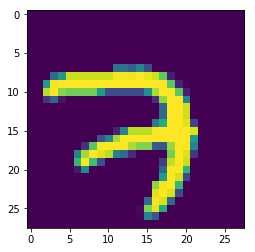

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(mnist.train.images[0].reshape(28, 28))

# One hot label to integer label

In [5]:
import numpy as np
train_label_int = np.argmax(mnist.train.labels, axis=1)
test_label_int = np.argmax(mnist.test.labels, axis=1)

In [6]:
train_label_int_5 = (train_label_int == 5)
test_label_int_5 = (test_label_int == 5)

In [7]:
print(train_label_int_5)
print(test_label_int_5)

[False False False ...  True False False]
[False False False ... False  True False]


# Model training

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter= 5, random_state= 42)
sgd_clf.fit(mnist.train.images, train_label_int_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

# Validation model

## 1.Cross Validation

In [9]:
mnist.train.images.shape

(55000, 784)

In [10]:
train_label_int_5.shape

(55000,)

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state= 42)

for train_idx, test_idx in skfolds.split(mnist.train.images, train_label_int_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = mnist.train.images[train_idx]
    y_train_folds = train_label_int_5[train_idx]
    x_test_folds = mnist.train.images[test_idx]
    y_test_folds = train_label_int_5[test_idx]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9628013526780844
0.9644902634593356
0.9668903070964927


In [12]:
from sklearn.base import BaseEstimator

class Never5Classifer(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype= bool)

In [13]:
from sklearn.model_selection import cross_val_score

never_5_clf = Never5Classifer()
cross_val_score(never_5_clf, mnist.train.images ,train_label_int_5, cv=3, scoring = "accuracy")
# Probablity of classifying 5 correctly is 9/10 so this is not good model for validation model

array([0.91087597, 0.90814378, 0.90896198])

## 2.Confusion matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, mnist.train.images, train_label_int_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_label_int_5, y_train_pred)

array([[48993,  1020],
       [  920,  4067]], dtype=int64)

## 3.Recall, Precision

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(train_label_int_5, y_train_pred)

0.7994888932573226

In [17]:
recall_score(train_label_int_5, y_train_pred)

0.8155203529175857

In [18]:
#Calculate F1_score
from sklearn.metrics  import f1_score

f1_score(train_label_int_5, y_train_pred)

0.8074250545959897

## 4.Trade off Recall with Precision

In [19]:
np.where(5 == train_label_int)

(array([   27,    28,    56, ..., 54968, 54993, 54997], dtype=int64),)

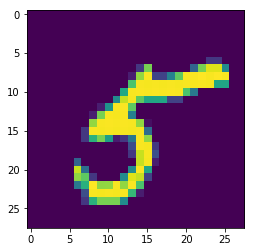

In [20]:
some_digit = mnist.train.images[27]
plt.imshow(some_digit.reshape(28, 28))

In [21]:
y_score = sgd_clf.decision_function([some_digit])
print(y_score)

[8.03403386]


In [22]:
thresh = 0
y_some_digit_pred = (y_score > thresh)
y_some_digit_pred

array([ True])

In [23]:
thresh = 20000
y_some_digit_pred = (y_score > thresh)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, mnist.train.images, train_label_int_5, cv = 3, method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresh, = precision_recall_curve(train_label_int_5, y_scores)

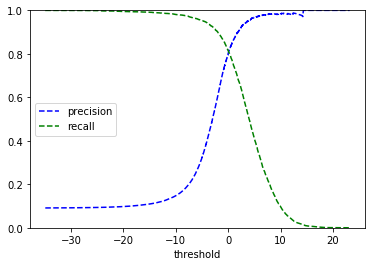

In [26]:
def plot_pre_recall_vs_thresh(precision, recall, thresh):
    plt.plot(thresh, precision[:-1], "b--", label="precision")
    plt.plot(thresh, recall[:-1], "g--", label="recall")
    plt.xlabel("threshold")
    plt.legend(loc = "center left")
    plt.ylim([0, 1])
    plt.show()
    
plot_pre_recall_vs_thresh(precision, recall, thresh)

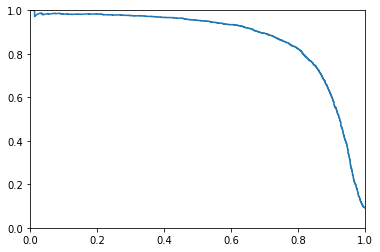

In [27]:
plt.plot(recall, precision)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()

#You can choose proper threshold for your projcet

In [28]:
y_train_pred_90 = (y_scores > 2)

In [29]:
precision_score(train_label_int_5, y_train_pred_90)

0.9045832216563924

In [30]:
recall_score(train_label_int_5, y_train_pred_90)

0.6767595748947263

## 5.ROC curve

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresh = roc_curve(train_label_int_5, y_scores)

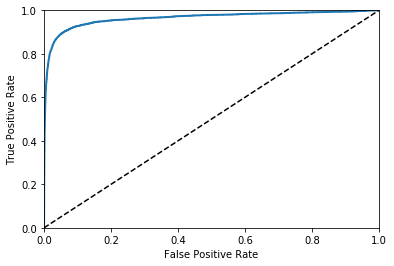

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
#Good classify model is far from y = x 

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_label_int_5, y_scores)

0.9641496980586531

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, mnist.train.images, train_label_int_5, cv = 3,
                                   method="predict_proba")

In [35]:
y_probas_forest

array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [0.1, 0.9],
       [0.9, 0.1],
       [0.8, 0.2]])

In [36]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresh_forest = roc_curve(train_label_int_5, y_scores_forest)

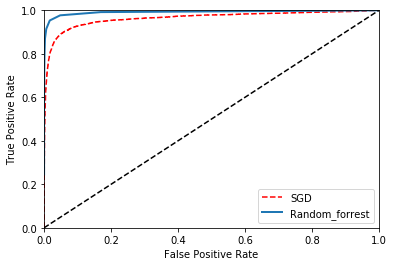

In [37]:
plt.plot(fpr, tpr, "r--", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random_forrest")
plt.legend(loc= "lower right")
plt.show()

In [38]:
roc_auc_score(train_label_int_5, y_scores_forest)

0.9919874472099857

# Let's apply original label

In [39]:
sgd_clf.fit(mnist.train.images, train_label_int)
sgd_clf.predict([mnist.train.images[27]])

array([5], dtype=int64)

In [40]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [43]:
sgd_clf.classes_[5]

5

In [44]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter = 5, random_state=42))
ovo_clf.fit(mnist.train.images, train_label_int)
ovo_clf.predict([some_digit])

array([5], dtype=int64)

In [45]:
len(ovo_clf.estimators_)

45

In [46]:
forest_clf.fit(mnist.train.images, train_label_int)
forest_clf.predict([some_digit])

array([5], dtype=int64)

In [47]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0.9, 0. , 0. , 0. , 0. ]])

In [48]:
cross_val_score(sgd_clf, mnist.train.images, train_label_int, cv=3, scoring="accuracy")

array([0.88585919, 0.88741613, 0.86410256])

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(mnist.train.images.astype(np.float64))

In [50]:
cross_val_score(sgd_clf, x_train_scaled, train_label_int, cv=3, scoring="accuracy")

array([0.90598244, 0.90776196, 0.91260229])

# Error Analysis

In [51]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, train_label_int, cv = 3)
conf_mx = confusion_matrix(train_label_int, y_train_pred)

In [52]:
conf_mx

array([[5257,    3,   22,    8,   12,   42,   49,    8,   39,    4],
       [   1, 5918,   45,   20,    5,   38,    5,   14,  124,    9],
       [  48,   30, 4915,   87,   64,   20,   79,   56,  154,   17],
       [  56,   41,  125, 4884,    1,  210,   37,   54,  140,   90],
       [  14,   23,   35,    8, 4860,   10,   51,   28,   79,  199],
       [  72,   35,   34,  167,   66, 4224,  107,   25,  176,   81],
       [  28,   22,   40,    2,   40,   93, 5146,    3,   43,    0],
       [  17,   22,   69,   24,   43,   11,    5, 5308,   18,  198],
       [  50,  138,   60,  127,   11,  141,   54,   25, 4662,  121],
       [  35,   29,   23,   75,  154,   36,    2,  213,   78, 4809]],
      dtype=int64)

In [53]:
import matplotlib.cm

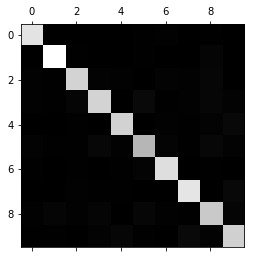

In [54]:
import matplotlib.pyplot as plt
plt.matshow(conf_mx, cmap=matplotlib.cm.gray)
plt.show()

In [55]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

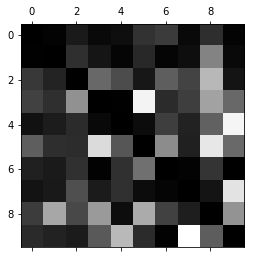

In [56]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=matplotlib.cm.gray)
plt.show()
#row -> Label
#column -> Esitmated Label

# Multi-Lable Classfy

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (train_label_int > 6)
y_train_odd = (train_label_int % 2 == 1)
y_multi_label = np.c_[y_train_large, y_train_odd]

In [58]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(mnist.train.images, y_multi_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [59]:
knn_clf.predict([some_digit])
#some_digit -> images refer 5

array([[False,  True]])

In [60]:
# y_train_knn_pred = cross_val_predict(knn_clf, mnist.train.images, y_multi_label, cv=3, n_jobs= -1)
# f1_score(y_multi_label, y_train_knn_pred, average="macro")

# Multi-output classify

In [100]:
#Hands on ML's data type is [0, 255] integer but tf.mnist data is [0, 1] float so i use random instead randint
noise = np.random.random([len(mnist.train.images), 784])
X_train_noisy = mnist.train.images + noise
noise = np.random.random([len(mnist.test.images), 784])
X_test_noisy = mnist.test.images + noise
y_train_mod = mnist.train.images
y_test_mod = mnist.test.images

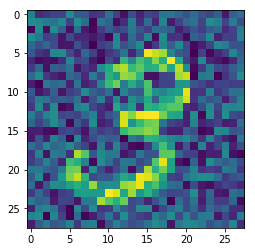

In [101]:
plt.imshow(X_train_noisy[1].reshape(28, 28))

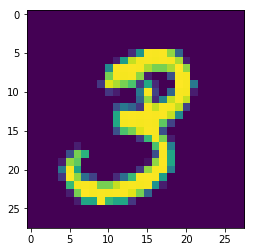

In [102]:
plt.imshow(mnist.train.images[1].reshape(28, 28))